In [2]:
import numpy as np
import xgboost
import librosa
from sklearn.model_selection import train_test_split
from sklearn import metrics
import treelite,treelite.runtime
from matplotlib import pyplot as plt
import librosa.display

In [ ]:
train_p_path = "/home/qinjianbo/DATA/audio_sample/positive_samples/all.npy"
train_n_path = "/home/qinjianbo/DATA/audio_sample/negetive_samples/all.npy"

In [ ]:
train_p = np.load(train_p_path)
train_n = np.load(train_n_path)

data_X = np.concatenate((train_p,train_n))
shape_train_p = train_p.shape[0]
shape_train_n = train_n.shape[0]
data_Y = np.concatenate((np.array([1] * shape_train_p),np.array([0] * shape_train_n)))
X_train,X_test,Y_train,Y_test = train_test_split(data_X,data_Y,test_size=0.2,shuffle=True)

In [7]:
np.save("/home/qinjianbo/DATA/audio_sample/train/X_train.npy",X_train)
np.save("/home/qinjianbo/DATA/audio_sample/train/X_test.npy",X_test)
np.save("/home/qinjianbo/DATA/audio_sample/train/Y_train",Y_train)
np.save("/home/qinjianbo/DATA/audio_sample/train/Y_test",Y_test)

In [5]:
Y_train.shape

(45692,)

In [28]:
data_Y.shape

(56956,)

In [29]:
modelXGB = xgboost.XGBClassifier(learning_rate=0.01,max_depth=100,max_feature=50,n_jobs=2)

In [30]:
modelXGB.fit(data_X,data_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=100, max_feature=50, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=2, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [48]:
result = modelXGB.predict(test[:,:-1])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [212]:
metrics.roc_auc_score(test[:,-1],result)

0.9922492323724511

In [56]:
import treelite

In [58]:
model = treelite.Model.from_xgboost(modelXGB.get_booster())

[19:07:33] /io/treelite/src/frontend/xgboost.cc:277: Global bias of the model: -0
[19:07:33] /io/treelite/src/frontend/xgboost.cc:315: gbm_param_.num_feature = 512
[19:07:33] /io/treelite/src/frontend/xgboost.cc:316: gbm_param_.num_output_group = 1


In [59]:
model.export_srcpkg(platform='unix',toolchain='gcc',pkgpath='/home/qinjianbo/yinnao.zip',libname='yinnao.so')

[19:09:03] /io/treelite/src/compiler/recursive.cc:190: Parallel compilation disabled; all member trees will be dump to a single source file. This may increase compilation time and memory usage.


In [7]:
def cal_melspec(x):
    spec = librosa.feature.melspectrogram(x,sr=sr, n_mels=128, fmax=8000, n_fft=fft_size, hop_length=fft_size)
    spec = librosa.amplitude_to_db(spec,ref=np.max)
    #spec = spec.reshape(1,-1)[0]
    return spec

In [233]:
audio_file = "/home/qinjianbo/Downloads/捣衣_8000.mp3"
audio_file = "/home/qinjianbo/DATA/lable/meihua_8000.mp3"
audio_file = "/home/qinjianbo/Downloads/白雪_8000.mp3"

In [234]:
x,sr = librosa.load(audio_file,sr=8000,mono=True)

In [235]:
piece_time = 0.2

In [248]:
#specs = np.zeros([int(x.shape[0] / (0.2*sr)),512])
specs = []
n_points = int(piece_time * sr)

In [251]:
for i in range(int(x.shape[0] / n_points)):
    start_point = i * n_points
    if(x.shape[0] - start_point >=n_points):
        pass
    else:
        break
    end_point   = (i + 1) * n_points
    piece = x[start_point:end_point]
    spec = cal_melspec(piece)
    specs.append(spec)
specs = np.array(specs)

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:261: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [255]:
specs[6].shape

(128, 7)

In [135]:
import treelite,treelite.runtime

In [238]:
predictor = treelite.runtime.Predictor("/home/qinjianbo/Downloads/yinnao/yinnao.so")
batch = treelite.runtime.Batch.from_npy2d(specs)

In [239]:
predics = predictor.predict(batch)

In [241]:
predics

array([0.18359391, 0.18359391, 0.18359391, ..., 0.18359391, 0.18359391,
       0.18359391], dtype=float32)

/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


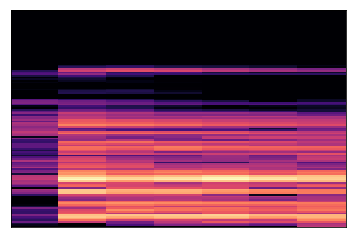

In [265]:
librosa.display.specshow(specs[7])

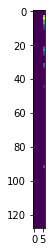

In [260]:
plt.imshow(specs[6].reshape(128,-1))

In [16]:
#test_case = "/home/qinjianbo/DATA/audio_sample/negetive_samples/meihua_8000/audio/478.126_39.wav"
test_case = "/home/qinjianbo/DATA/audio_sample/samples/乌夜啼/audio/乌夜啼_107.wav"

In [17]:
x_test_case,sr = librosa.load(test_case,sr=8000,mono=True)

In [18]:
x_test_case.shape
fft_size = 256

In [19]:
spec_test_case = cal_melspec(x_test_case).reshape(1,-1)

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:271: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


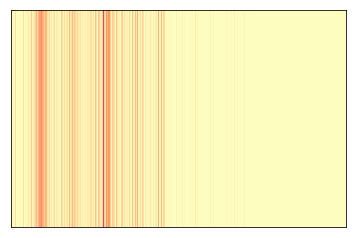

In [20]:
librosa.display.specshow(librosa.amplitude_to_db(spec_test_case,ref=np.max))

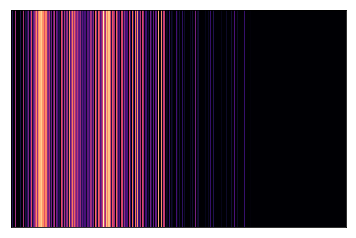

In [21]:
librosa.display.specshow(spec_test_case)

In [22]:
def cal_spec(x):
    spec = librosa.spectrum(x,sr=sr, n_mels=128, fmax=8000, n_fft=fft_size, hop_length=fft_size)
    spec = librosa.amplitude_to_db(spec,ref=np.max)
    spec = spec.reshape(1,-1)[0]
    return spec

In [283]:
wyt_p = np.load("/home/qinjianbo/DATA/audio_sample/positive_samples/乌夜啼.npy")

In [3]:
p_case = "/home/qinjianbo/DATA/audio_sample/positive_samples/乌夜啼/audio/45.768.wav"
n_case = "/home/qinjianbo/DATA/audio_sample/negetive_samples/乌夜啼/audio/71.69_0.wav"

In [4]:

def cal_melspec(x):
    spec = librosa.feature.melspectrogram(x,sr=sr, n_mels=128, fmax=sr, n_fft=fft_size,hop_length=fft_size)
    spec = librosa.amplitude_to_db(spec,ref=np.max)
    #spec = spec.reshape(1,-1)[0]
    return spec

In [37]:
fft_size = 256
x,sr = librosa.load(test_case,sr=44100,mono=True)
spec = cal_melspec(x)
#librosa.display.specshow(spec)

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:271: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


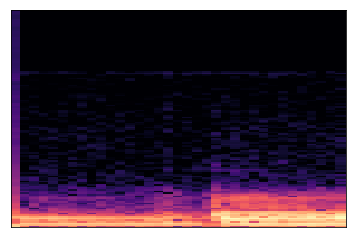

In [38]:
stft_spec = librosa.stft(x,n_fft=fft_size,hop_length=fft_size,window='hanning')
stft_spec = librosa.amplitude_to_db(stft_spec,ref=np.max)
a = librosa.display.specshow(stft_spec,x_axis='off',y_axis='off')
#a = librosa.display.specshow(stft_spec,y_axis='off')